In [1]:
import cv2
import numpy as np
from PIL import Image
from main import init_detectron, create_mask, resize, get_classes
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
get_classes()

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [3]:
img = cv2.imread("data/6001481133_06841baef7_c.jpg")
Image.fromarray(img[...,::-1])
im = img

/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


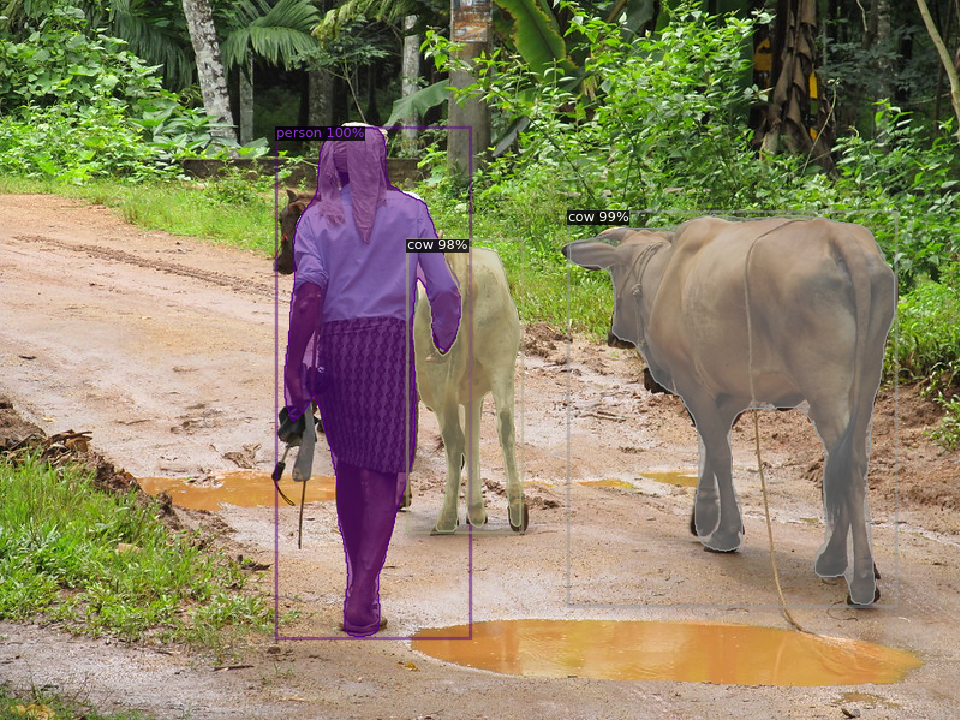

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(out.get_image())

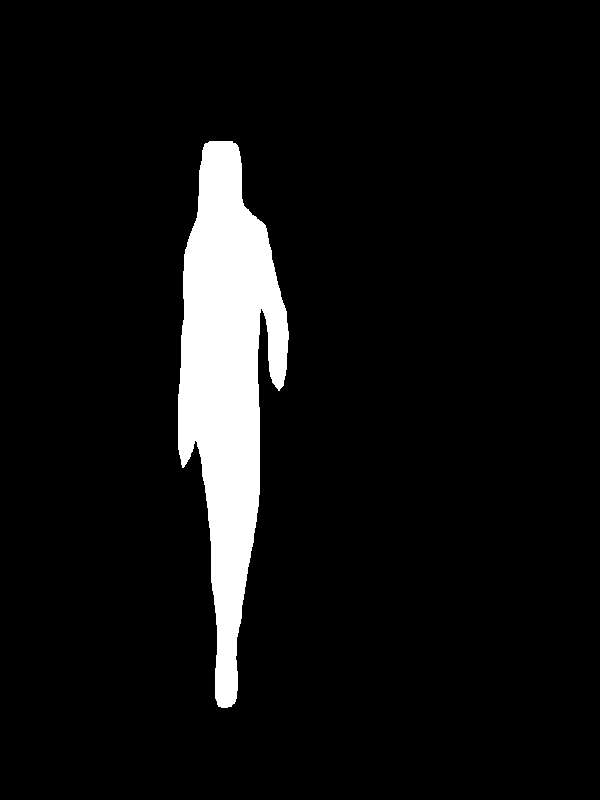

In [5]:
mask = outputs['instances'].pred_masks.cpu().numpy()[0].astype(np.uint8) * 255
imgg = cv2.resize(mask, (600,800))
imgg = cv2.threshold(imgg, None, 255, cv2.THRESH_OTSU)
Image.fromarray(imgg[1])

In [6]:
image = img
target_dims = (600, 900)

predictor, coi = init_detectron()
mask = create_mask(predictor, coi, image)
output1 = resize(image, target_dims, None)
output2 = resize(image, target_dims, mask)

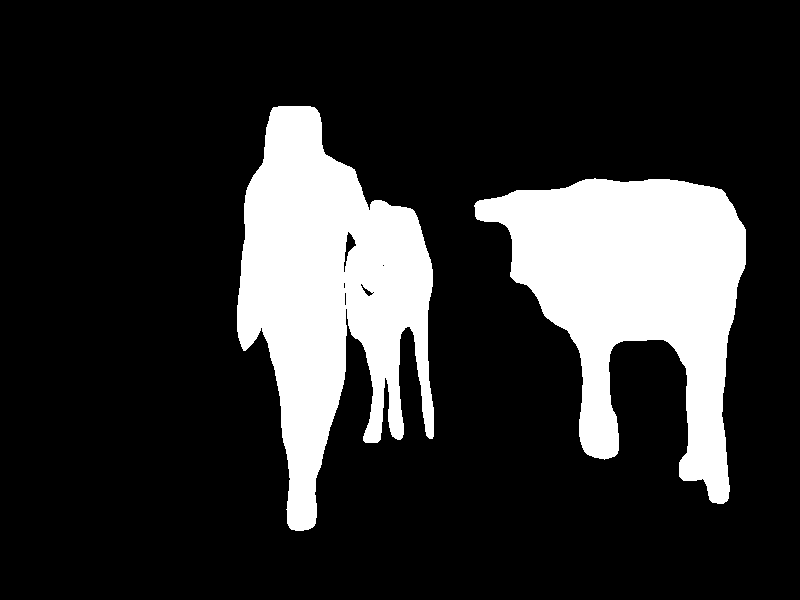

In [7]:
Image.fromarray(mask)

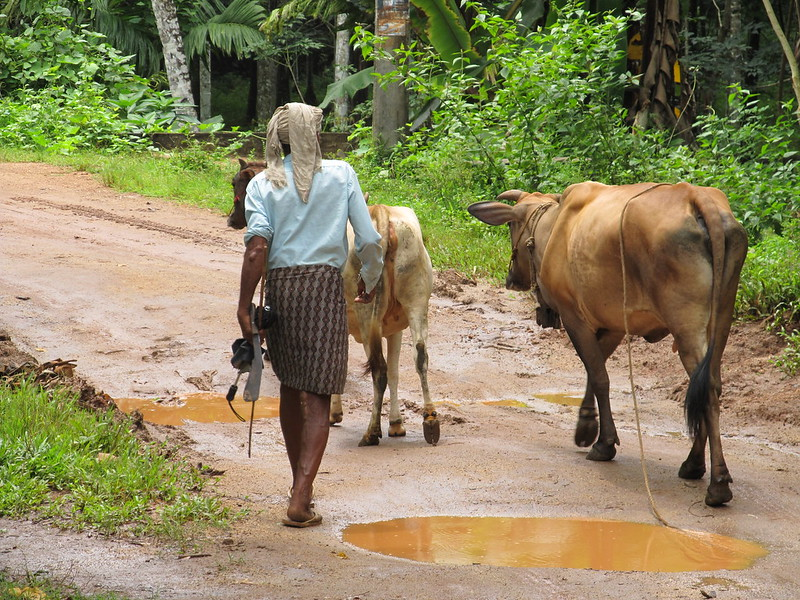

In [8]:
Image.fromarray(img[...,::-1])

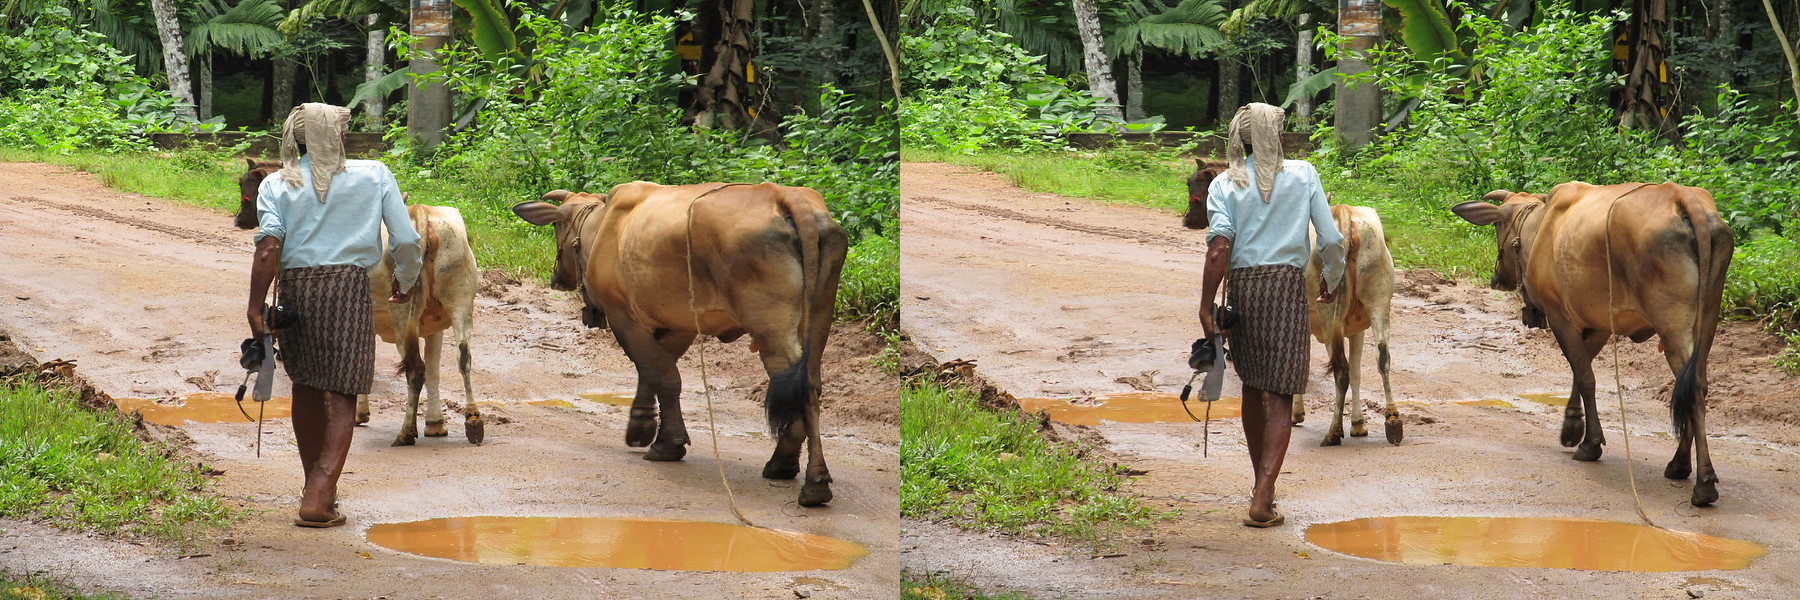

In [9]:
Image.fromarray(np.hstack((output1[...,::-1].astype(np.uint8),output2[...,::-1].astype(np.uint8))))

/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


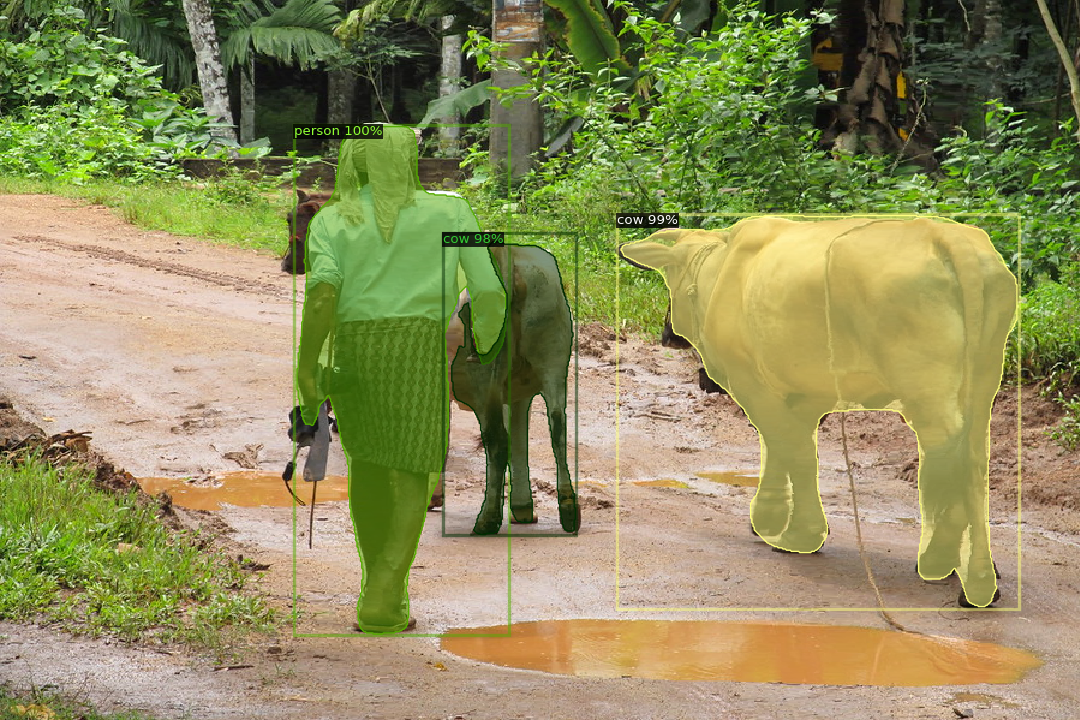

In [10]:
outputs = predictor(output1.astype(np.uint8))
v = Visualizer(output1[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(out.get_image())

In [19]:
from sklearn.metrics import jaccard_score

def crop_image(img):
    minx, miny, maxx, maxy = 0, 0, img.shape[1], img.shape[0]
    while not img[miny, :].any():
        miny += 1
    while not img[maxy - 1, :].any():
        maxy -= 1
    while not img[:, minx].any():
        minx += 1
    while not img[:, maxx - 1].any():
        maxx -= 1
    return img[miny:maxy, minx:maxx]

def foreground_score(src_img, rec_img, predictor, coi):
    src_outs, rec_outs = predictor(src_img), predictor(rec_img)
    src_masks, rec_masks = src_outs['instances'].pred_masks.cpu().numpy(), rec_outs['instances'].pred_masks.cpu().numpy()
    filter_func = lambda x: x.item() in coi
    src_coi, rec_coi = list(map(filter_func, src_outs['instances'].pred_classes)), list(map(filter_func, rec_outs['instances'].pred_classes))
    src_masks, rec_masks = src_masks[src_coi], rec_masks[rec_coi]
    if len(src_masks) != len(rec_masks):
        print(len(src_masks))
        print(len(rec_masks))
        return np.nan
    values, weights = [], []
    for i in range(len(src_masks)):
        src_mask, rec_mask = crop_image(src_masks[i]), crop_image(rec_masks[i])
        rec_mask = cv2.resize(rec_mask.astype(np.uint8) * 255, src_mask.shape[::-1])
        _, rec_mask = cv2.threshold(rec_mask, 127, 255, cv2.THRESH_BINARY)
        weights.append(np.sum(src_mask))
        values.append(jaccard_score(src_mask, rec_mask, average="micro"))
    return np.average(np.array(values), weights=np.array(weights))
    

In [20]:
predictor, coi = init_detectron()
print(foreground_score(img, output1.astype(np.uint8), predictor, coi))
print(foreground_score(img, output2.astype(np.uint8), predictor, coi))

/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


0.9089235608463873
0.9315271450632405


/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
